In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from osgeo import gdal
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
import dateutil.parser as parser

In [3]:
train_labels = pd.read_csv("dataset/metadata/train_labels.csv")
grid_metadata = pd.read_csv("dataset/metadata/grid_metadata.csv") #use this to download data
satellite_metadata = pd.read_csv("dataset/metadata/satellite_metadata.csv")
satellite_metadata['Date'] =  pd.to_datetime(satellite_metadata['time_end'], format='%Y-%m-%d')

In [4]:
train_labels.shape

(34312, 3)

In [5]:
train_labels.head()

,datetime,grid_id,value
0,2018-02-01T08:00:00Z,3S31A,11.4
1,2018-02-01T08:00:00Z,A2FBI,17.0
2,2018-02-01T08:00:00Z,DJN0F,11.1
3,2018-02-01T08:00:00Z,E5P9N,22.1
4,2018-02-01T08:00:00Z,FRITQ,29.8


grid_metadata: Metadata for each grid cell in the train and test sets.

In [6]:
grid_metadata.shape

(54, 4)

In [7]:
grid_metadata.head()

,grid_id,location,tz,wkt
0,1X116,Taipei,Asia/Taipei,"POLYGON ((121.5257644471362 24.97766123020391,..."
1,1Z2W7,Delhi,Asia/Calcutta,"POLYGON ((77.30453178416276 28.54664454217707,..."
2,3S31A,Los Angeles (SoCAB),Etc/GMT+8,POLYGON ((-117.9338248256995 33.79558357488509...
3,6EIL6,Delhi,Asia/Calcutta,"POLYGON ((77.07995296313287 28.54664454217707,..."
4,7334C,Delhi,Asia/Calcutta,"POLYGON ((77.12486872733885 28.54664454217707,..."


In [8]:
grid_metadata['location'].unique()

array(['Taipei', 'Delhi', 'Los Angeles (SoCAB)'], dtype=object)

satellite_metadata: Metadata for each granule in the train and test sets, including file location in each public s3 bucket.

Note that each file for a particular dataset is referred to as a `granule`. The metadata csv contains the following columns:

    - `granule_id` (str): the filename for each granule
    - `time_start` (datetime): the start time of the granule in YYYY-DD-MMTHH:mm:ss.sssZ
    - `time_end` (datetime): the end time of the granule in YYYY-DD-MMTHH:mm:ss.sssZ
    - `product` (str): concise name for satellite data source
    - `location` (str): one of the three locations for this challenge
    - `us_url` (str): file location of the granule in the public s3 bucket in the US East (N. Virginia) region
    - `eu_url` (str): file location of the granule in the public s3 bucket in the Europe (Frankfurt) region
    - `as_url` (str): file location of the granule in the public s3 bucket in the Asia Pacific (Singapore) region
    - `cksum` (int): the result of running the unix cksum command on the granule
    - `granule_size` (int): the filesize in bytes

In [9]:
satellite_metadata.shape

(7721, 12)

dataset                 | n     (TOTAL:7721)
    -------------------------------------------
    
	pm25/train/maiac/       | 4260  | 35.1GB
	pm25/train/misr/        |  788  | 27.3GB
	pm25/test/maiac/        | 2444  | 20.3GB
	pm25/test/misr/         |  229  |  7.9GB


In [10]:
satellite_metadata.head()

,granule_id,time_start,time_end,product,location,split,us_url,eu_url,as_url,cksum,granule_size,Date
0,20180201T191000_maiac_la_0.hdf,2018-02-01T17:25:00.000Z,2018-02-01 19:10:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,911405771,10446736,2018-02-01 19:10:00+00:00
1,20180202T195000_maiac_la_0.hdf,2018-02-02T18:05:00.000Z,2018-02-02 19:50:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,2244451908,11090180,2018-02-02 19:50:00+00:00
2,20180203T203000_maiac_la_0.hdf,2018-02-03T17:10:00.000Z,2018-02-03 20:30:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,3799527997,12468482,2018-02-03 20:30:00+00:00
3,20180204T194000_maiac_la_0.hdf,2018-02-04T17:55:00.000Z,2018-02-04 19:40:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,4105997844,13064424,2018-02-04 19:40:00+00:00
4,20180205T202000_maiac_la_0.hdf,2018-02-05T17:00:00.000Z,2018-02-05 20:20:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,1805072340,12549313,2018-02-05 20:20:00+00:00


In [11]:
####################
# REMOVE THIS LINE #
####################
train_labels = train_labels.sample(2, random_state=42)

In [12]:
train_labels

,datetime,grid_id,value
24050,2020-05-14T18:30:00Z,A7UCQ,52.333333
25046,2020-06-04T18:30:00Z,SZLMT,49.538462


In [13]:
def get_grid_data(metadata, grid_id):
    return metadata[metadata["grid_id"] == grid_id]

In [14]:
def fetch_satellite_meta(metadata, datetime, location, datatype, split):
    if location == "Delhi":
        location = "dl"
    elif location == "Taipei":
        location = "tpe"
    else:
        location = "la"
    
    #filtering
    metadata = metadata[metadata['location'] == location]
    metadata = metadata[metadata['product'] == datatype]
    metadata = metadata[metadata['split'] == split]
    dateobject = parser.parse(datetime)
    return metadata.loc[(metadata['Date'].dt.month == dateobject.month) & 
                        (metadata['Date'].dt.day == dateobject.day) &
                        (metadata['Date'].dt.year <= dateobject.year)]

In [15]:
# Opens the HDF file
def load_data(FILEPATH):
    ds = gdal.Open(FILEPATH)
    return ds

def fetch_subset(granule_id):
    ds = load_data("dataset/" + granule_id)
    ds.GetSubDatasets()[0]
    raster = gdal.Open(ds.GetSubDatasets()[8][0]) #grid5km:cosSZA features only
    band = raster.GetRasterBand(1)
    band_arr = band.ReadAsArray()
    return band_arr

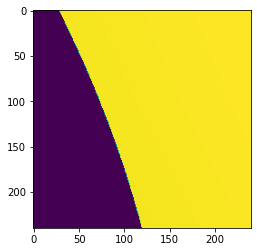

In [18]:
g_id = '20200604T070000_maiac_dl_0.hdf'
arr = fetch_subset(g_id)
plt.imshow(arr)

In [19]:
def fetch_training_features(grid_id, datetime, split):
    temp = get_grid_data(grid_metadata, grid_id)
    sat_met = fetch_satellite_meta(satellite_metadata, 
                               datetime, 
                               temp.iloc[0]['location'], 
                               "maiac", # or 'misr'
                               split)
    counter = 0
    features = None
    for i in range(len(sat_met)):
        counter+=1
        granule_id = sat_met.iloc[i]['granule_id']
        subset = fetch_subset(granule_id)
        if features is None:
            features = subset
        else:
            features+=subset
#             print(counter, len(features))
    return features/counter #average of same date across years?

In [20]:
def generate_features(train_labels, split):
    labels = []
    features = []
    for i in range(len(train_labels)):
        feature = fetch_training_features(train_labels.iloc[i]['grid_id'], train_labels.iloc[i]['datetime'], split)
#         feature = np.array(feature).reshape(-1) #flatten to 57600 = 240*240
        features.append(feature) 
        if split == "train": #only available for training
            labels.append(train_labels.iloc[i]['value'])
    return np.array(features), np.array(labels)

In [21]:
len(train_labels['grid_id'].unique())

2

In [22]:
train_labels_samples = train_labels[train_labels['datetime'].str.contains('2020-06-04')]
delhi_grids = grid_metadata[grid_metadata['location']=='Delhi']['grid_id']
train_labels_samples = train_labels_samples[train_labels_samples['grid_id'].isin(delhi_grids)]
# train_labels_samples = train_labels_samples.iloc[0:4]
train_labels_samples

,datetime,grid_id,value
25046,2020-06-04T18:30:00Z,SZLMT,49.538462


In [23]:
ddd = satellite_metadata[satellite_metadata['us_url'] == 's3://drivendata-competition-airathon-public-us/pm25/train/maiac/2020/20200604T070000_maiac_dl_0.hdf']
ddd

,granule_id,time_start,time_end,product,location,split,us_url,eu_url,as_url,cksum,granule_size,Date
4049,20200604T070000_maiac_dl_0.hdf,2020-06-04T05:15:00.000Z,2020-06-04 07:00:00+00:00,maiac,dl,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,2937961848,10435128,2020-06-04 07:00:00+00:00


In [24]:
features, labels = generate_features(train_labels_samples, "train")

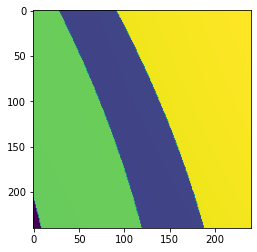

In [26]:
import matplotlib.pyplot as plt
plt.imshow(features[0])

In [27]:
labels.shape

(1,)

In [28]:
def baseline_model():
    model = Sequential()
    #add CNN 240*240
    model.add(Dense(1, input_dim=57600, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

estimator = KerasRegressor(build_fn=baseline_model, epochs=10, batch_size=5, verbose=0)
results = cross_val_score(estimator, features, labels)
print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))

/var/folders/3v/yrsdtsln2833mlkhfz9t_crh0000gn/T/ipykernel_20542/1010997953.py:9: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  estimator = KerasRegressor(build_fn=baseline_model, epochs=10, batch_size=5, verbose=0)


ValueError: Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=1.